In [ ]:
import marimo as mo

# Lab 1: MIT 6.S184
Simulating ODEs(Ordinary Differential Equations) and SDEs(Stochastic Differential Equations)

---
## Mathematical Formulations

### ODEs
- Vector Field : $u: \mathbb{R}^{d\times [0, 1]} \mapsto R^{d}$, $u(x, t) = u_t(x)$<br>
- initial condition $x_0\in \mathbb{R}^d$, find $X: [0, 1] \mapsto \mathbb{R}^d$, with notational simplicity($X_t(x) = X(t)$


$X_0 = x_0$<br>
$\displaystyle \frac{dX_t}{dt} = u_t(X_t)$

In [ ]:
from abc import ABC, abstractmethod
from typing import Optional
import math

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.axes._axes import Axes
import torch
import torch.distributions as D
from torch.func import vmap, jacrev
from tqdm import tqdm
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")

Running on device: cpu


In [ ]:
class ODE(ABC):
    @abstractmethod
    def drift_coefficient(
        self, xt: torch.Tensor, t: torch.Tensor
    ) -> torch.Tensor:
        """
        Returns the drift coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs, dim)
            - t: time, shape ()
        Returns:
            - drift_coefficient: shape (batch_size, dim)
        """
        pass


class SDE(ABC):
    @abstractmethod
    def drift_coefficient(
        self, xt: torch.Tensor, t: torch.Tensor
    ) -> torch.Tensor:
        """
        Returns the drift coefficient of the SDE.
        Args:
            - xt: state at time t, shape (batch_size, dim)
            - t: time, shape ()
        Returns:
            - drift_coefficient: shape (batch_size, dim)
        """
        pass

    @abstractmethod
    def diffusion_coefficient(
        self, xt: torch.Tensor, t: torch.Tensor
    ) -> torch.Tensor:
        """
        Returns the diffusion coefficient of the SDE.
        Args:
            - xt: state at time t, shape (batch_size, dim)
            - t: time, shape ()
        Returns:
            - diffusion_coefficient: shape (batch_size, dim)
        """
        pass

It is clear that ODEs are special case of SDEs($\sigma_t = 0$). <br> We will treat them separately for performance reasons
## Part 1: Numerical methods for simulating solutions to ODEs and SDEs.
**For solving ODEs**<br>
$dX_t = u_t(X_t) \implies X_{t + h} = X_t + hu_t(X_t)$ for arbitrary small h
**For Solving SDEs**<br>
$dX_t = u_t(X_t) + \sigma_t dW_t \implies X_{t + h} = X_t + hu_tX_t + \sigma_t\left(W_{t + h} - W_t\right)$<br>
$=X_t + hu_tX_t + \sigma_t\sqrt{h} + z_t$ where $z_t\sim \mathcal{N}(0, I_d)$

In [ ]:
class Simulator(ABC):
    @abstractmethod
    def step(self, xt: torch.Tensor, t: torch.Tensor, dt: torch.Tensor):
        """
        Takes one simulation step
        Args:
            - xt: state at time t, shape (batch_size, dim)
            - t: time, shape ()
            - dt: time, shape ()
        Returns:
            - nxt: state at time t + dt
        """
        pass

    @torch.no_grad()
    def simulate(self, x: torch.Tensor, ts: torch.Tensor):
        """
        Simulates using the discretization gives by ts
        Args:
            - x_init: initial state at time ts[0], shape (batch_size, dim)
            - ts: timesteps, shape (nts,)
        Returns:
            - x_fina: final state at time ts[-1], shape (batch_size, dim)
        """
        for t_idx in range(len(ts) - 1):
            t = ts[t_idx]
            h = ts[t_idx + 1] - ts[t_idx]
            x = self.step(x, t, h)
        return x

    @torch.no_grad()
    def simulate_with_trajectory(self, x: torch.Tensor, ts: torch.Tensor):
        """
        Simulates using the discretization gives by ts
        Args:
            - x_init: initial state at time ts[0], shape (bs, dim)
            - ts: timesteps, shape (num_timesteps,)
        Returns:
            - xs: trajectory of xts over ts, shape (batch_size, num_timesteps, dim)
        """
        xs = [x.clone()]
        for t_idx in tqdm(range(len(ts) - 1)):
            t = ts[t_idx]
            h = ts[t_idx + 1] - ts[t_idx]
            x = self.step(x, t, h)
            xs.append(x.clone())
        return torch.stack(xs, dim=1)

In [ ]:
class EulerSimulator(Simulator):
    def __init__(self, ode: ODE):
        self.ode = ode

    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor):
        return xt + h * self.ode.drift_coefficient(xt, t)


class EulerMaruyamaSimulator(Simulator):
    def __init__(self, sde: SDE):
        self.sde = sde

    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor):
        return (
            xt
            + h * self.sde.drift_coefficient(xt, t)
            + self.sde.diffusion_coefficient(xt, t)
            * torch.sqrt(h)
            * torch.randn(*xt.shape)
        )

## Part 2: Visualising Solutions to SDEs
Let's get a feel for what the solutions to these SDEs look like in practice (we'll get to ODEs later...).

To do so, we we'll implement and visualize two special choices of SDEs from lecture: a (scaled) Brownian motion, and an Ornstein-Uhlenbeck (OU) process.

In [ ]:
class BrownianMotion(SDE):
    def __init__(self, sigma: float):
        self.sigma = sigma

    def drift_coefficient(
        self, xt: torch.Tensor, t: torch.Tensor
    ) -> torch.Tensor:
        """
        Returns the drift coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs, dim)
            - t: time, shape ()
        Returns:
            - drift: shape (bs, dim)
        """
        return torch.zeros(xt.shape)

    def diffusion_coefficient(
        self, xt: torch.Tensor, t: torch.Tensor
    ) -> torch.Tensor:
        """
        Returns the diffusion coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs, dim)
            - t: time, shape ()
        Returns:
            - diffusion: shape (bs, dim)
        """
        return torch.ones(xt.shape) * self.sigma

In [ ]:
def plot_trajectories_1d(
    x0: torch.Tensor,
    simulator: Simulator,
    timesteps: torch.Tensor,
    ax: Optional[Axes] = None,
    show_hist: bool = False,
    decouple_hist_axis: bool = False,
):
    """
    Graphs the trajectories of a one-dimensional SDE with given initial values (x0) and simulation timesteps (timesteps).
    Args:
        - x0: state at time t, shape (num_trajectories, 1)
        - simulator: Simulator object used to simulate
        - t: timesteps to simulate along, shape (num_timesteps,)
        - ax: pyplot Axes object to plot on
        - decouple_hist_axis: if True, do not share y-axis between trajectories and histogram
    """
    if ax is None:
        ax = plt.gca()
    trajectories = simulator.simulate_with_trajectory(
        x0, timesteps
    )  # (num_trajectories, num_timesteps, ...)

    line_color = sns.color_palette("crest", 1)[0]
    hist_color = sns.color_palette("flare", 1)[0]
    label_size = 12
    tick_size = 10

    timesteps_cpu = timesteps.detach().cpu().numpy()
    for trajectory_idx in range(trajectories.shape[0]):
        trajectory = (
            trajectories[trajectory_idx, :, 0].detach().cpu().numpy()
        )  # (num_timesteps,)
        sns.lineplot(
            x=timesteps_cpu,
            y=trajectory,
            ax=ax,
            color=line_color,
            alpha=0.45,
            linewidth=1.1,
            legend=False,
        )

    ax.set_xlabel(r"time ($t$)", fontsize=label_size)
    ax.set_ylabel(r"$X_t$", fontsize=label_size)
    ax.tick_params(axis="both", labelsize=tick_size)
    ax.grid(alpha=0.2, linewidth=0.6)

    if show_hist:
        terminal_points = trajectories[:, -1, 0].detach().cpu().numpy()
        data_range = (
            float(terminal_points.max() - terminal_points.min())
            if terminal_points.size
            else 1.0
        )
        binwidth = max(data_range / 25.0, 0.05)

        from mpl_toolkits.axes_grid1 import make_axes_locatable

        divider = make_axes_locatable(ax)
        sharey = None if decouple_hist_axis else ax
        hist_ax = divider.append_axes(
            "right", size="22%", pad=0.45, sharey=sharey
        )
        sns.histplot(
            y=terminal_points,
            ax=hist_ax,
            binwidth=binwidth,
            color=hist_color,
            alpha=0.7,
            edgecolor="white",
            linewidth=0.5,
        )
        hist_ax.set_xlabel("count", fontsize=label_size)
        hist_ax.set_ylabel("")
        hist_ax.tick_params(axis="both", labelsize=tick_size)
        if decouple_hist_axis:
            hist_ax.tick_params(axis="y", left=True, labelleft=True)
        else:
            hist_ax.tick_params(axis="y", left=False, labelleft=False)
        hist_ax.grid(axis="x", alpha=0.2, linewidth=0.6)

    fig = ax.figure
    if fig is not None:
        title = ax.get_title()
        if title:
            title_size = ax.title.get_fontsize()
            ax.set_title("")

            axes = [ax]
            if show_hist:
                axes.append(hist_ax)

            fig.canvas.draw()
            bboxes = [a.get_position() for a in axes]

            left = min(b.x0 for b in bboxes)
            right = max(b.x1 for b in bboxes)
            top = max(b.y1 for b in bboxes)

            x_center = 0.5 * (left + right)
            y = top + 0.005

            fig.text(
                x_center,
                y,
                title,
                ha="center",
                va="bottom",
                fontsize=title_size,
            )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499/499 [00:00<00:00, 20408.35it/s]


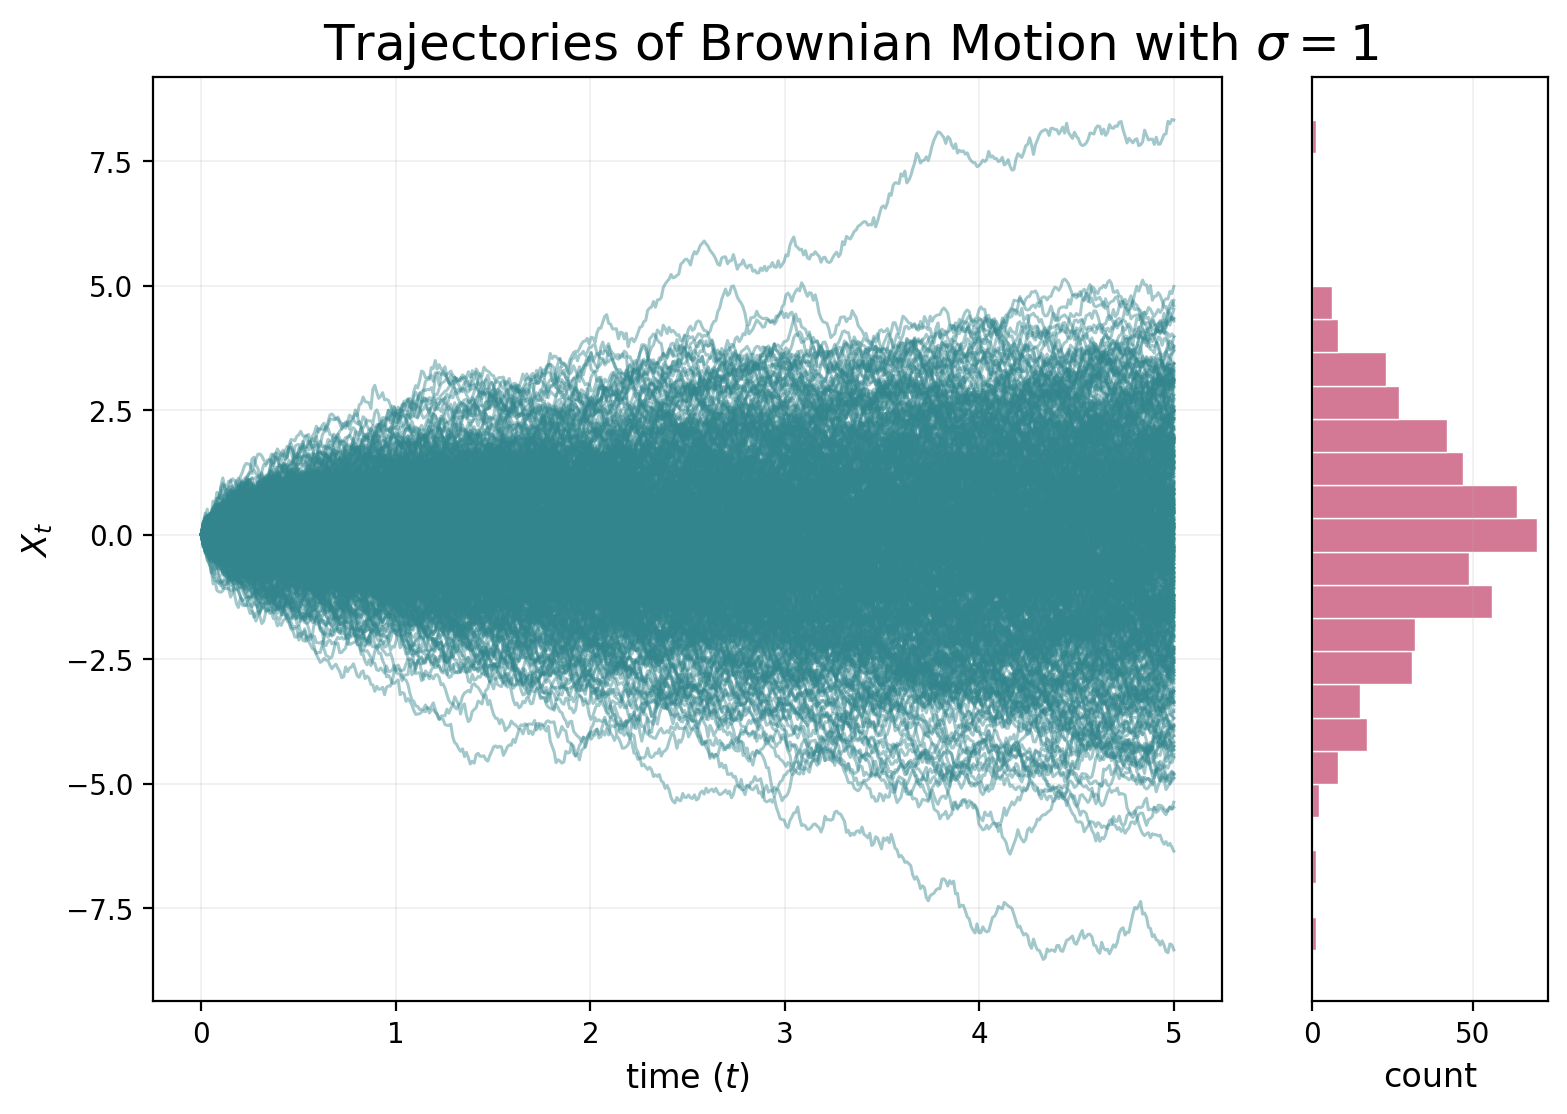

In [ ]:
plot_brownian_tracjectories(sigma=sigma_slider.value)

In [ ]:
def plot_brownian_tracjectories(sigma=1.0, n_traj=500):
    brownian_motion = BrownianMotion(sigma)
    simulator = EulerMaruyamaSimulator(sde=brownian_motion)
    x0 = torch.zeros(n_traj, 1).to(
        device
    )  # Initial values - let's start at zero
    ts = torch.linspace(0.0, 5.0, 500).to(device)  # simulation timesteps

    plt.figure(figsize=(9, 6))
    ax = plt.gca()
    ax.set_title(
        r"Trajectories of Brownian Motion with $\sigma=$" + str(sigma),
        fontsize=18,
    )
    ax.set_xlabel(r"time ($t$)", fontsize=18)
    ax.set_ylabel(r"$x_t$", fontsize=18)
    plot_trajectories_1d(x0, simulator, ts, ax, show_hist=True)
    plt.show()


sigma_slider = mo.ui.slider(start=1, stop=10, step=1)
sigma_slider

**Implementing an Ornstein-Uhlenbeck Process**

Here $u_t = -\theta x_t$ and $\sigma_t = \sigma$

In [ ]:
class OUProcess(SDE):
    def __init__(self, theta: float, sigma: float):
        self.theta = theta
        self.sigma = sigma

    def drift_coefficient(
        self, xt: torch.Tensor, t: torch.Tensor
    ) -> torch.Tensor:
        """
        Returns the drift coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs, dim)
            - t: time, shape ()
        Returns:
            - drift: shape (bs, dim)
        """
        return -self.theta * xt

    def diffusion_coefficient(
        self, xt: torch.Tensor, t: torch.Tensor
    ) -> torch.Tensor:
        """
        Returns the diffusion coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs, dim)
            - t: time, shape ()
        Returns:
            - diffusion: shape (bs, dim)
        """
        return torch.ones(xt.shape) * self.sigma

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 47523.62it/s]


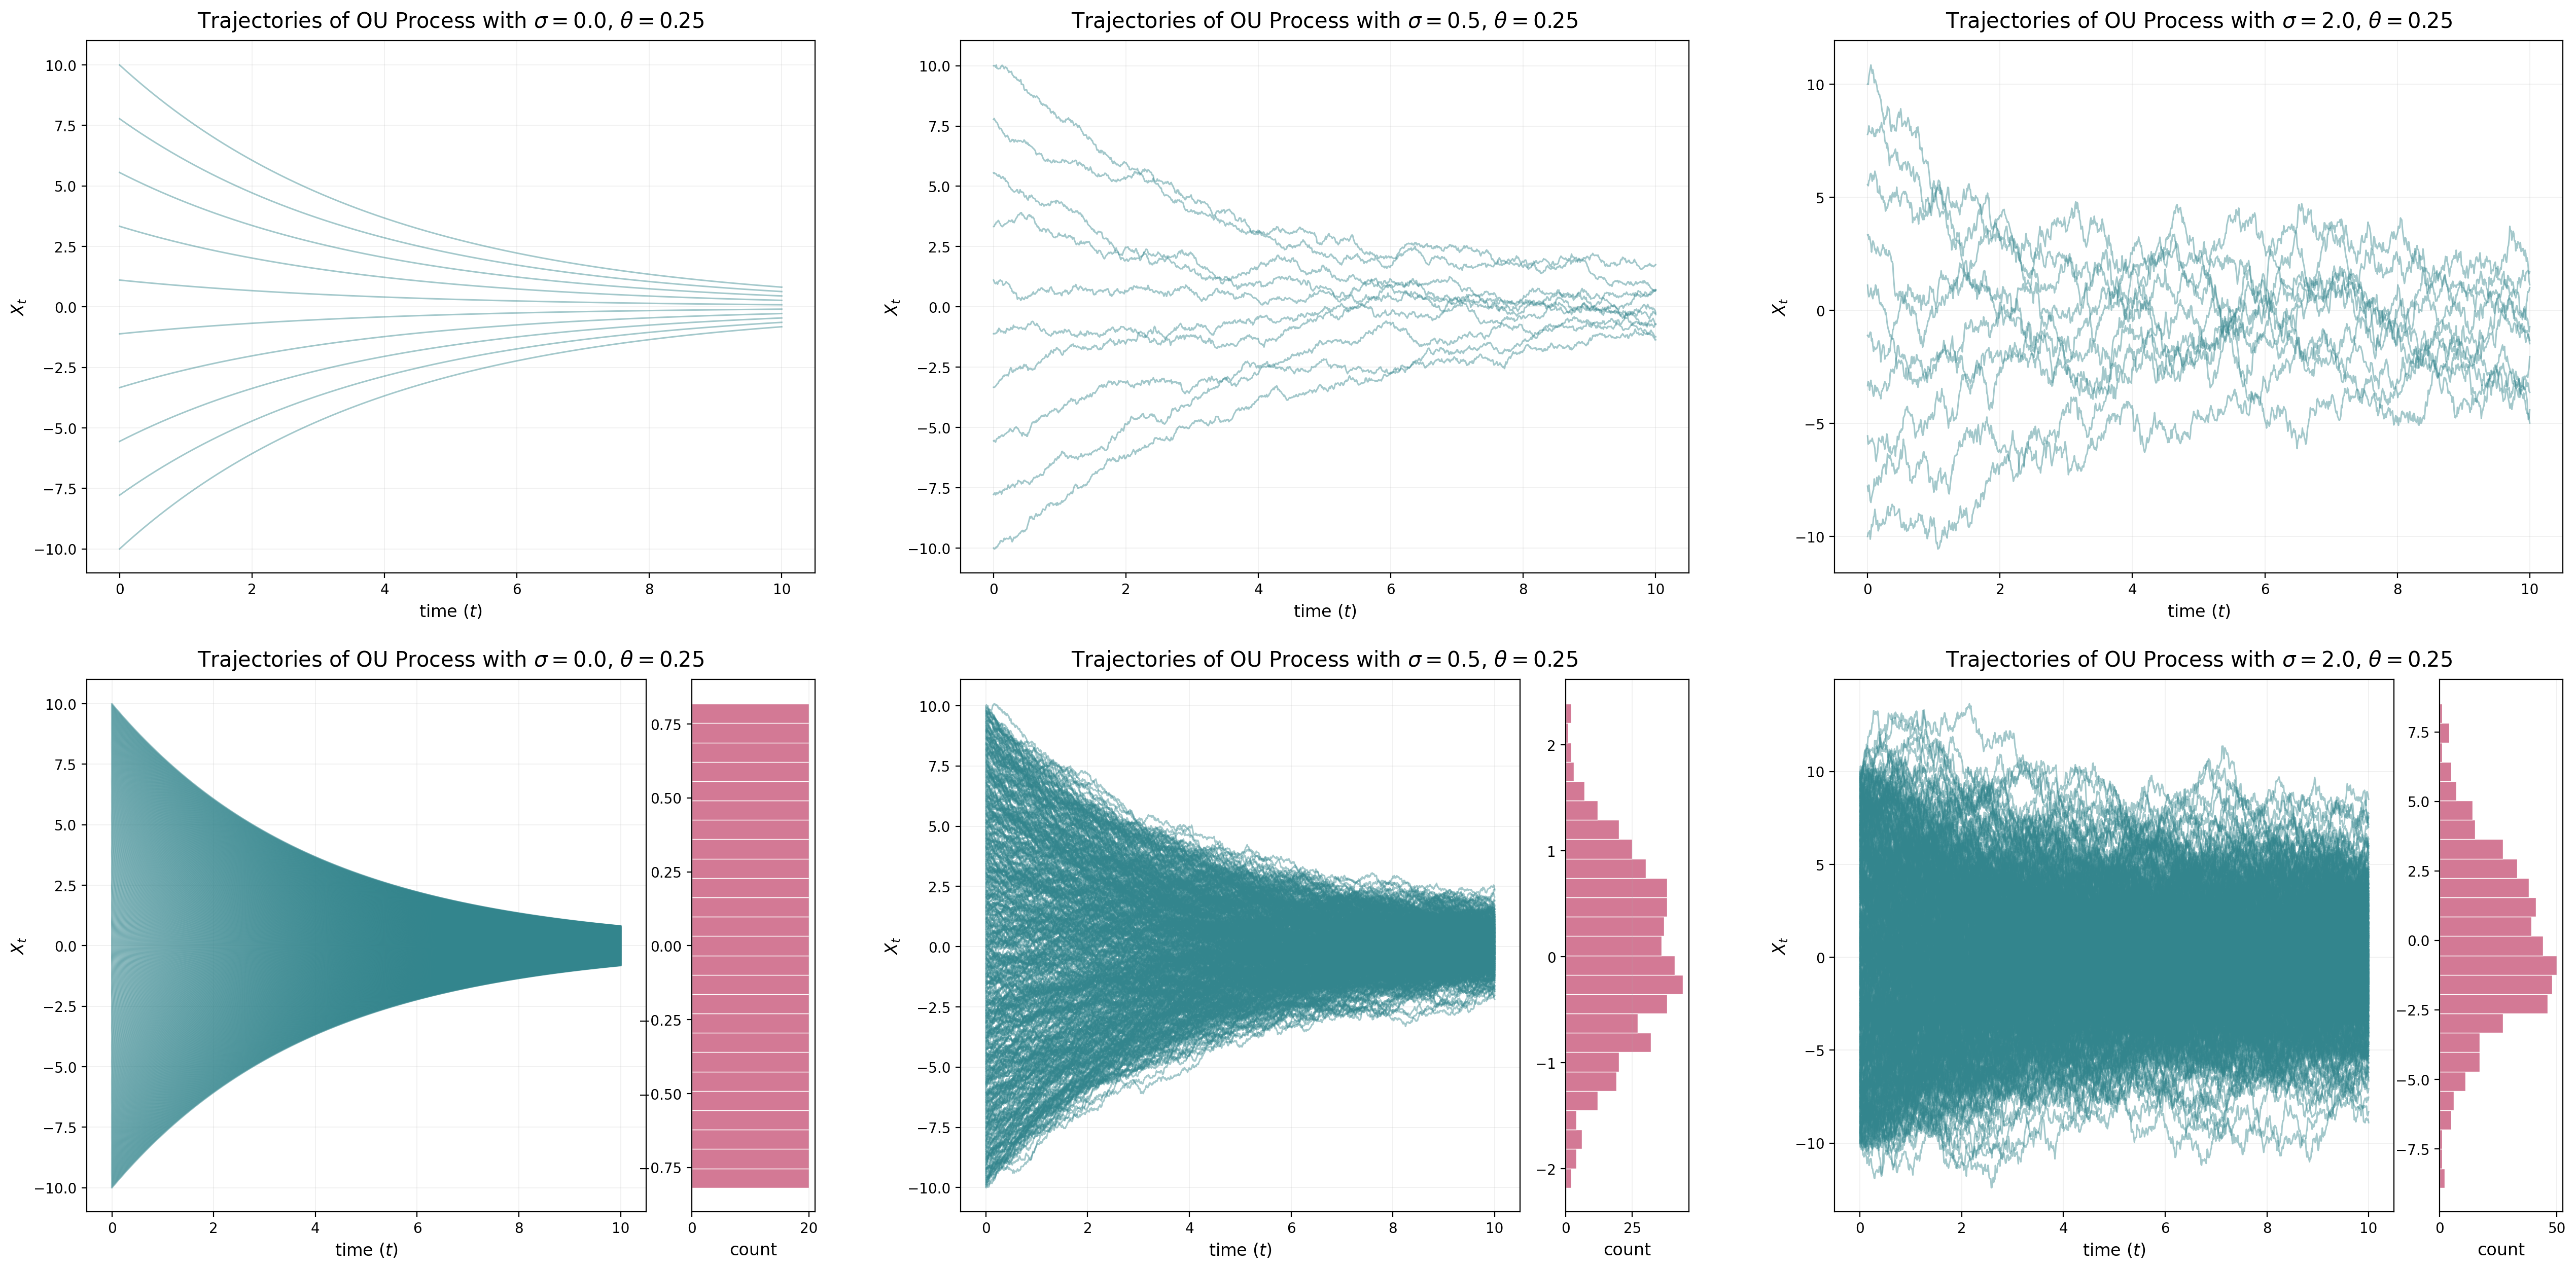

In [ ]:


def plot_ou_sde():
    thetas_and_sigmas = [
        (0.25, 0.0),
        (0.25, 0.5),
        (0.25, 2.0),
    ]
    simulation_time = 10.0

    num_plots = len(thetas_and_sigmas)
    fig, axes = plt.subplots(2, num_plots, figsize=(10.5 * num_plots, 15))

    # Top row: dynamics
    n_traj = 10
    for idx, (theta, sigma) in enumerate(thetas_and_sigmas):
        ou_process = OUProcess(theta, sigma)
        simulator = EulerMaruyamaSimulator(sde=ou_process)
        x0 = torch.linspace(-10.0,10.0,n_traj).view(-1,1).to(device) # Initial values - let's start at zero
        ts = torch.linspace(0.0,simulation_time,1000).to(device) # simulation timesteps

        ax = axes[0,idx]
        ax.set_title(f'Trajectories of OU Process with $\\sigma = ${sigma}, $\\theta = ${theta}', fontsize=15)
        plot_trajectories_1d(x0, simulator, ts, ax, show_hist=False)

    # Bottom row: distribution
    n_traj = 500
    for idx, (theta, sigma) in enumerate(thetas_and_sigmas):
        ou_process = OUProcess(theta, sigma)
        simulator = EulerMaruyamaSimulator(sde=ou_process)
        x0 = torch.linspace(-10.0,10.0,n_traj).view(-1,1).to(device) # Initial values - let's start at zero
        ts = torch.linspace(0.0,simulation_time,1000).to(device) # simulation timesteps

        ax = axes[1,idx]
        ax.set_title(f'Trajectories of OU Process with $\\sigma = ${sigma}, $\\theta = ${theta}', fontsize=15)
        ax = plot_trajectories_1d(x0, simulator, ts, ax, show_hist=True, decouple_hist_axis=True)
    plt.show()
plot_ou_sde()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 45672.75it/s]


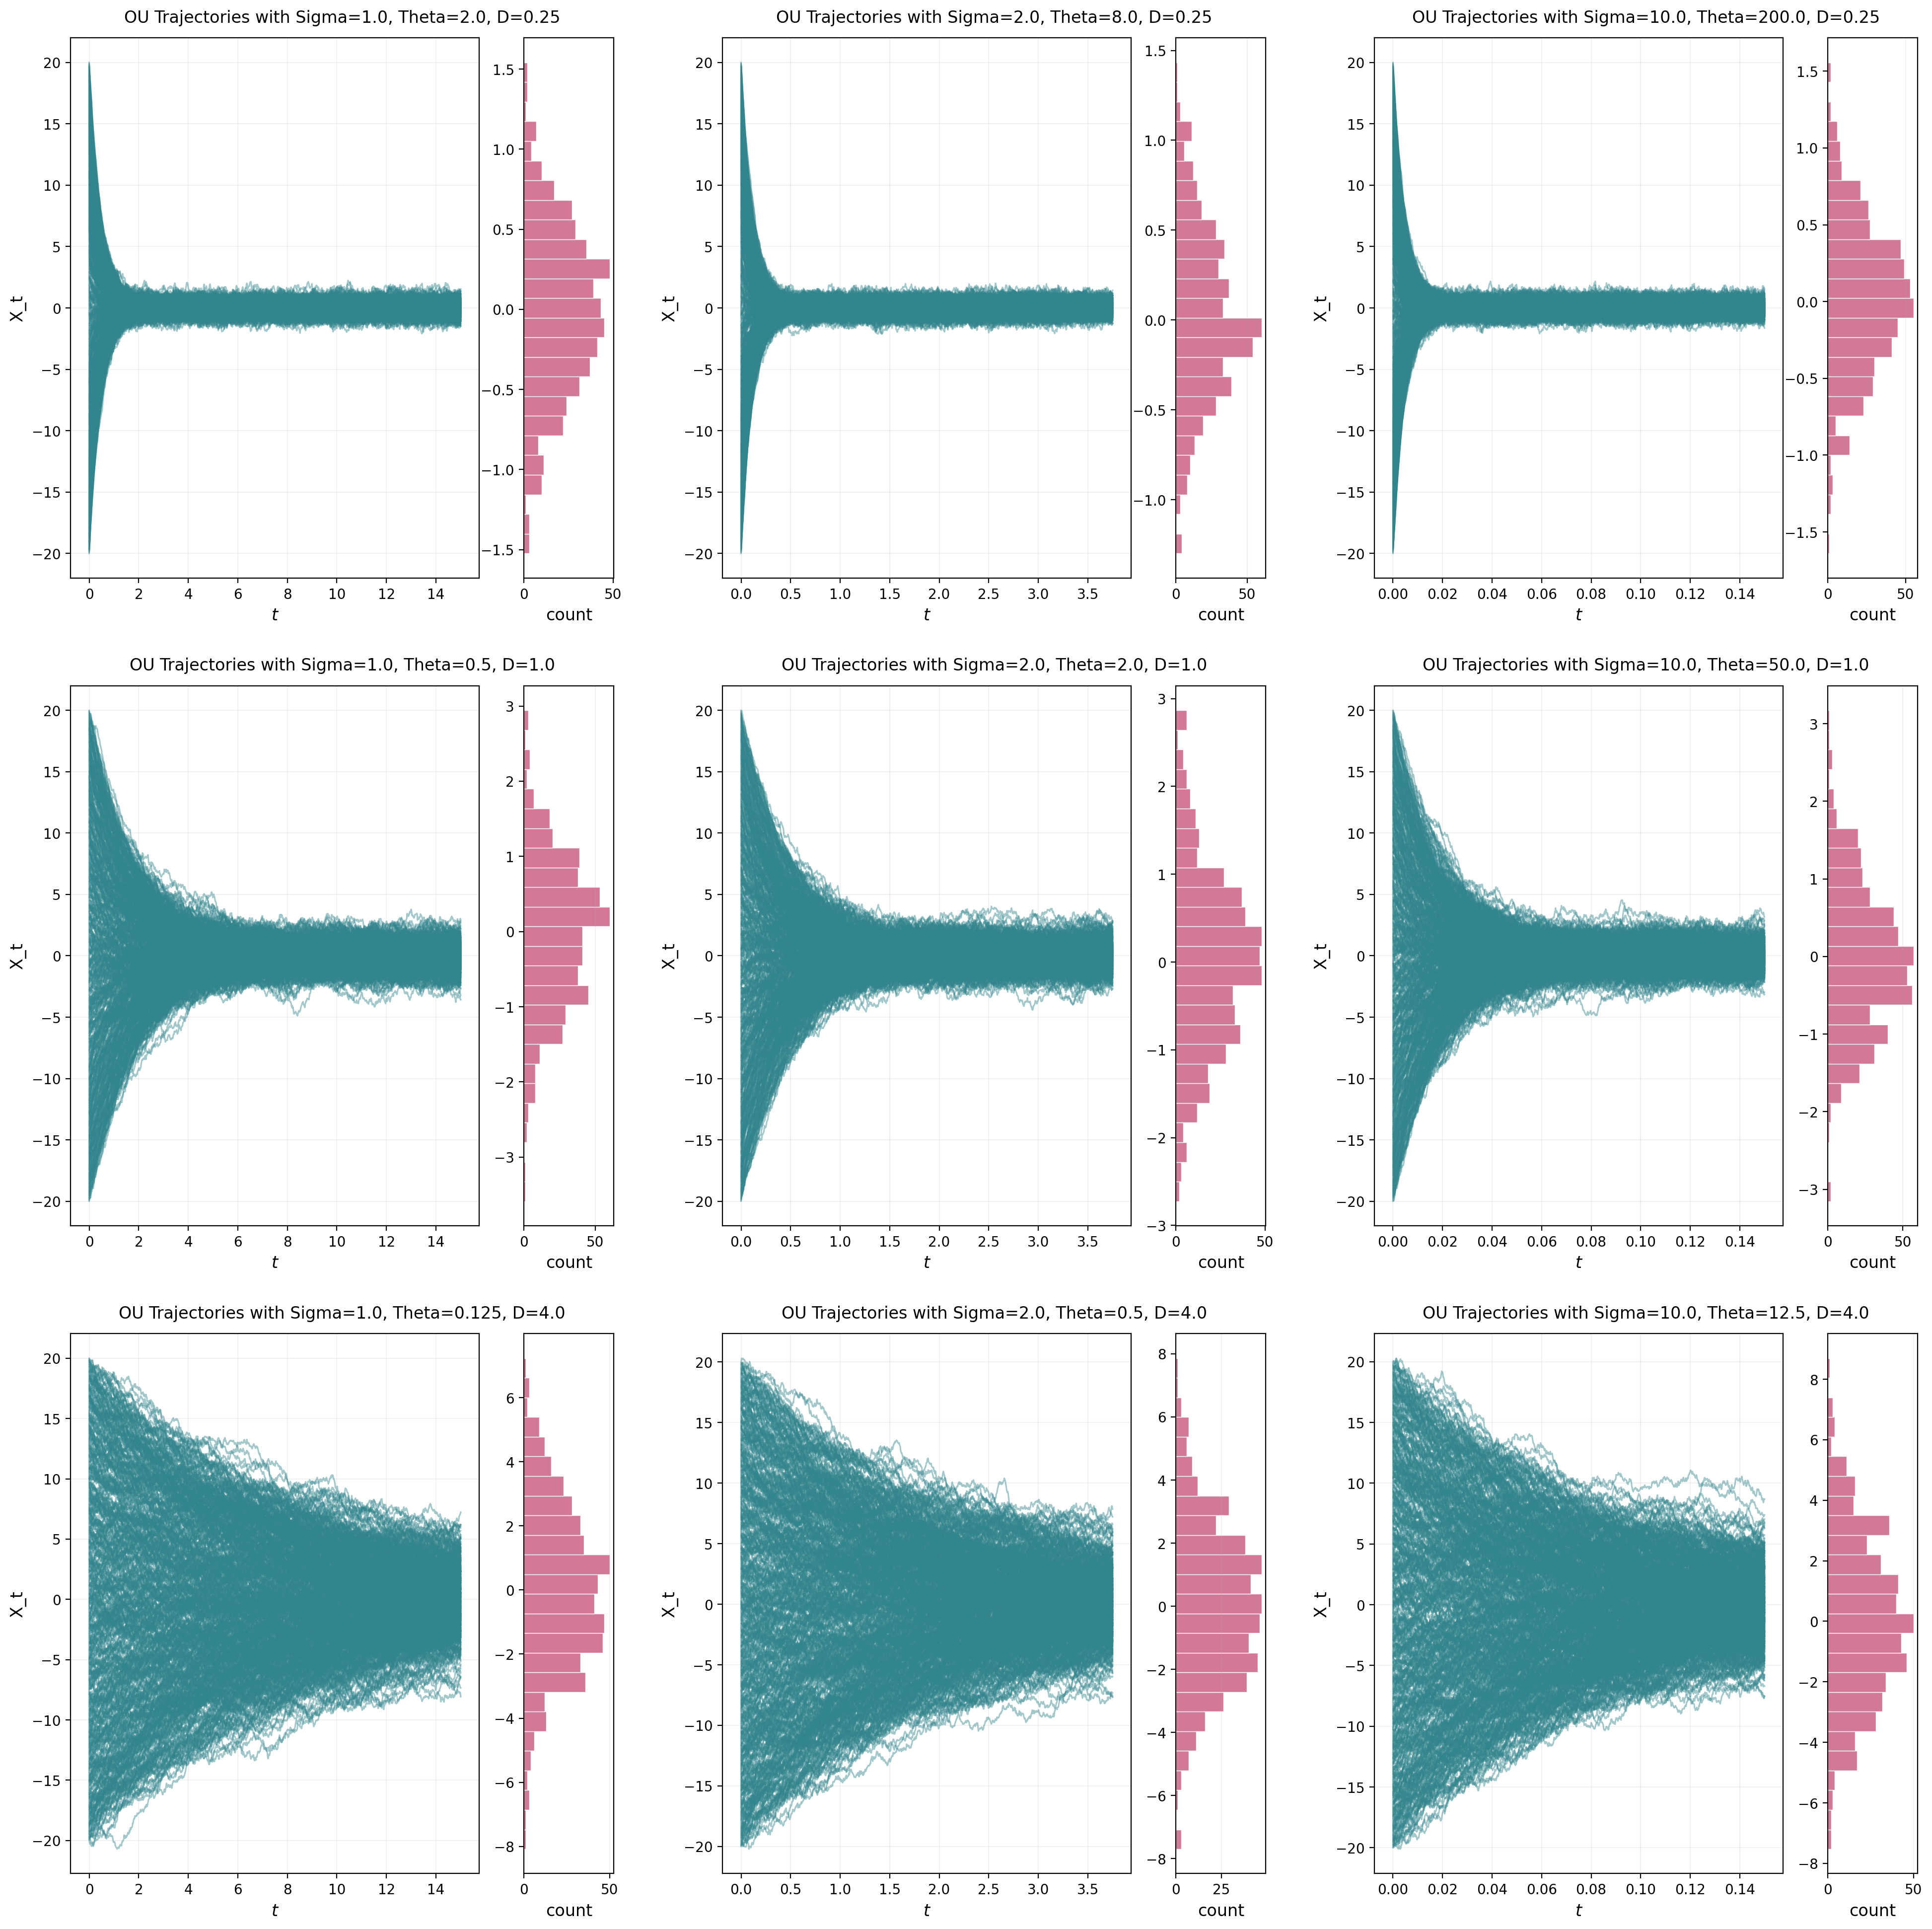

In [ ]:
def examine_ou_sde_dist():
    sigmas = [1.0, 2.0, 10.0]
    ds = [0.25, 1.0, 4.0] # sigma**2 / 2t
    simulation_time = 15.0
    n_traj = 500

    fig, axes = plt.subplots(len(ds), len(sigmas), figsize=(8 * len(sigmas), 8 * len(ds)))
    axes = axes.reshape((len(ds), len(sigmas)))
    for d_idx, d in enumerate(ds):
        for s_idx, sigma in enumerate(sigmas):
            theta = sigma**2 / 2 / d
            ou_process = OUProcess(theta, sigma)
            simulator = EulerMaruyamaSimulator(sde=ou_process)
            x0 = torch.linspace(-20.0,20.0,n_traj).view(-1,1).to(device)
            time_scale = sigma**2
            ts = torch.linspace(0.0,simulation_time / time_scale,1000).to(device) # simulation timesteps
            ax = axes[d_idx, s_idx]
            ax.set_title(f'OU Trajectories with Sigma={sigma}, Theta={theta}, D={d}')
            plot_trajectories_1d(x0=x0, simulator=simulator, timesteps=ts, ax=ax, show_hist=True, decouple_hist_axis=True)
            ax.set_xlabel(r'$t$')
            ax.set_ylabel(r'X_t')
    plt.show()

examine_ou_sde_dist()

### Part 3: Transforming Distributions with SDEs

In the previous section, we observed how individual points are transformed by an SDE. Ultimately, we are interested in understanding how distributions are transformed by an SDE (or an ODE...). After all, our goal is to design ODEs and SDEs which transform a noisy distribution (such as the Gaussian ), to the data distribution of interest. In this section, we will visualize how distributions are transformed by a very particular family of SDEs: Langevin dynamics.

First, let's define some distributions to play around with. In practice, there are two qualities one might hope a distribution to have:

    The first quality is that one can measure the density of a distribution . This ensures that we can compute the gradient of the log density. This quantity is known as the score of , and paints a picture of the local geometry of the distribution. Using the score, we will construct and simulate the Langevin dynamics, a family of SDEs which "drive" samples toward the distribution . In particular, the Langevin dynamics preserve the distribution . In Lecture 2, we will make this notion of driving more precise.
    The second quality is that we can draw samples from the distribution . For simple, toy distributions, such as Gaussians and simple mixture models, it is often true that both qualities are satisfied. For more complex choices of , such as distributions over images, we can sample but cannot measure the density.

In these notes, we will emphasize distributions as first-class objects that we can sample from. We emphasize that in practice, this is cumbersome and one would instead opt for e.g., torch.randn and similar.

In [ ]:
class Density(ABC):
    """
    Distribution with tractable density
    """
    @abstractmethod
    def log_density(self, x: torch.Tensor) -> torch.Tensor:
        """
        Returns the log density at x.
        Args:
            - x: shape (batch_size, dim)
        Returns:
            - log_density: shape (batch_size, 1)
        """
        pass

    def score(self, x: torch.Tensor) -> torch.Tensor:
        """
        Returns the score dx log density(x)
        Args:
            - x: (batch_size, dim)
        Returns:
            - score: (batch_size, dim)
        """
        x = x.unsqueeze(1)  # (batch_size, 1, ...)
        score = vmap(jacrev(self.log_density))(x)  # (batch_size, 1, 1, 1, ...)
        return score.squeeze((1, 2, 3))  # (batch_size, ...)

class Sampleable(ABC):
    """
    Distribution which can be sampled from
    """
    @abstractmethod
    def sample(self, num_samples: int) -> torch.Tensor:
        """
        Returns the log density at x.
        Args:
            - num_samples: the desired number of samples
        Returns:
            - samples: shape (batch_size, dim)
        """
        pass

In [ ]:
# Several plotting utility functions
def hist2d_sampleable(sampleable: Sampleable, num_samples: int, ax: Optional[Axes] = None, **kwargs):
    if ax is None:
        ax = plt.gca()
    samples = sampleable.sample(num_samples) # (ns, 2)
    ax.hist2d(samples[:,0].cpu(), samples[:,1].cpu(), **kwargs)

def scatter_sampleable(sampleable: Sampleable, num_samples: int, ax: Optional[Axes] = None, **kwargs):
    if ax is None:
        ax = plt.gca()
    samples = sampleable.sample(num_samples) # (ns, 2)
    ax.scatter(samples[:,0].cpu(), samples[:,1].cpu(), **kwargs)

def imshow_density(density: Density, bins: int, scale: float, ax: Optional[Axes] = None, **kwargs):
    if ax is None:
        ax = plt.gca()
    x = torch.linspace(-scale, scale, bins).to(device)
    y = torch.linspace(-scale, scale, bins).to(device)
    X, Y = torch.meshgrid(x, y)
    xy = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=-1)
    density = density.log_density(xy).reshape(bins, bins).T
    im = ax.imshow(density.cpu(), extent=[-scale, scale, -scale, scale], origin='lower', **kwargs)

def contour_density(density: Density, bins: int, scale: float, ax: Optional[Axes] = None, **kwargs):
    if ax is None:
        ax = plt.gca()
    x = torch.linspace(-scale, scale, bins).to(device)
    y = torch.linspace(-scale, scale, bins).to(device)
    X, Y = torch.meshgrid(x, y)
    xy = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=-1)
    density = density.log_density(xy).reshape(bins, bins).T
    im = ax.contour(density.cpu(), extent=[-scale, scale, -scale, scale], origin='lower', **kwargs)


In [ ]:
class Gaussian(torch.nn.Module, Sampleable, Density):
    """
    Two-dimensional Gaussian. Is a Density and a Sampleable. Wrapper around torch.distributions.MultivariateNormal
    """
    def __init__(self, mean, cov):
        """
        mean: shape (2,)
        cov: shape (2,2)
        """
        super().__init__()
        self.register_buffer("mean", mean)
        self.register_buffer("cov", cov)

    @property
    def distribution(self):
        return D.MultivariateNormal(self.mean, self.cov, validate_args=False)

    def sample(self, num_samples) -> torch.Tensor:
        return self.distribution.sample((num_samples,))

    def log_density(self, x: torch.Tensor):
        return self.distribution.log_prob(x).view(-1, 1)

class GaussianMixture(torch.nn.Module, Sampleable, Density):
    """
    Two-dimensional Gaussian mixture model, and is a Density and a Sampleable. Wrapper around torch.distributions.MixtureSameFamily.
    """
    def __init__(
        self,
        means: torch.Tensor,  # nmodes x data_dim
        covs: torch.Tensor,  # nmodes x data_dim x data_dim
        weights: torch.Tensor,  # nmodes
    ):
        """
        means: shape (nmodes, 2)
        covs: shape (nmodes, 2, 2)
        weights: shape (nmodes, 1)
        """
        super().__init__()
        self.nmodes = means.shape[0]
        self.register_buffer("means", means)
        self.register_buffer("covs", covs)
        self.register_buffer("weights", weights)

    @property
    def dim(self) -> int:
        return self.means.shape[1]

    @property
    def distribution(self):
        return D.MixtureSameFamily(
                mixture_distribution=D.Categorical(probs=self.weights, validate_args=False),
                component_distribution=D.MultivariateNormal(
                    loc=self.means,
                    covariance_matrix=self.covs,
                    validate_args=False,
                ),
                validate_args=False,
            )

    def log_density(self, x: torch.Tensor) -> torch.Tensor:
        return self.distribution.log_prob(x).view(-1, 1)

    def sample(self, num_samples: int) -> torch.Tensor:
        return self.distribution.sample(torch.Size((num_samples,)))

    @classmethod
    def random_2D(
        cls, nmodes: int, std: float, scale: float = 10.0, seed = 0.0
    ) -> "GaussianMixture":
        torch.manual_seed(seed)
        means = (torch.rand(nmodes, 2) - 0.5) * scale
        covs = torch.diag_embed(torch.ones(nmodes, 2)) * std ** 2
        weights = torch.ones(nmodes)
        return cls(means, covs, weights)

    @classmethod
    def symmetric_2D(
        cls, nmodes: int, std: float, scale: float = 10.0,
    ) -> "GaussianMixture":
        angles = torch.linspace(0, 2 * np.pi, nmodes + 1)[:nmodes]
        means = torch.stack([torch.cos(angles), torch.sin(angles)], dim=1) * scale
        covs = torch.diag_embed(torch.ones(nmodes, 2) * std ** 2)
        weights = torch.ones(nmodes) / nmodes
        return cls(means, covs, weights)


/Users/zuhaib/Downloads/Projects/Diffusion/.venv/lib/python3.14/site-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4383.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


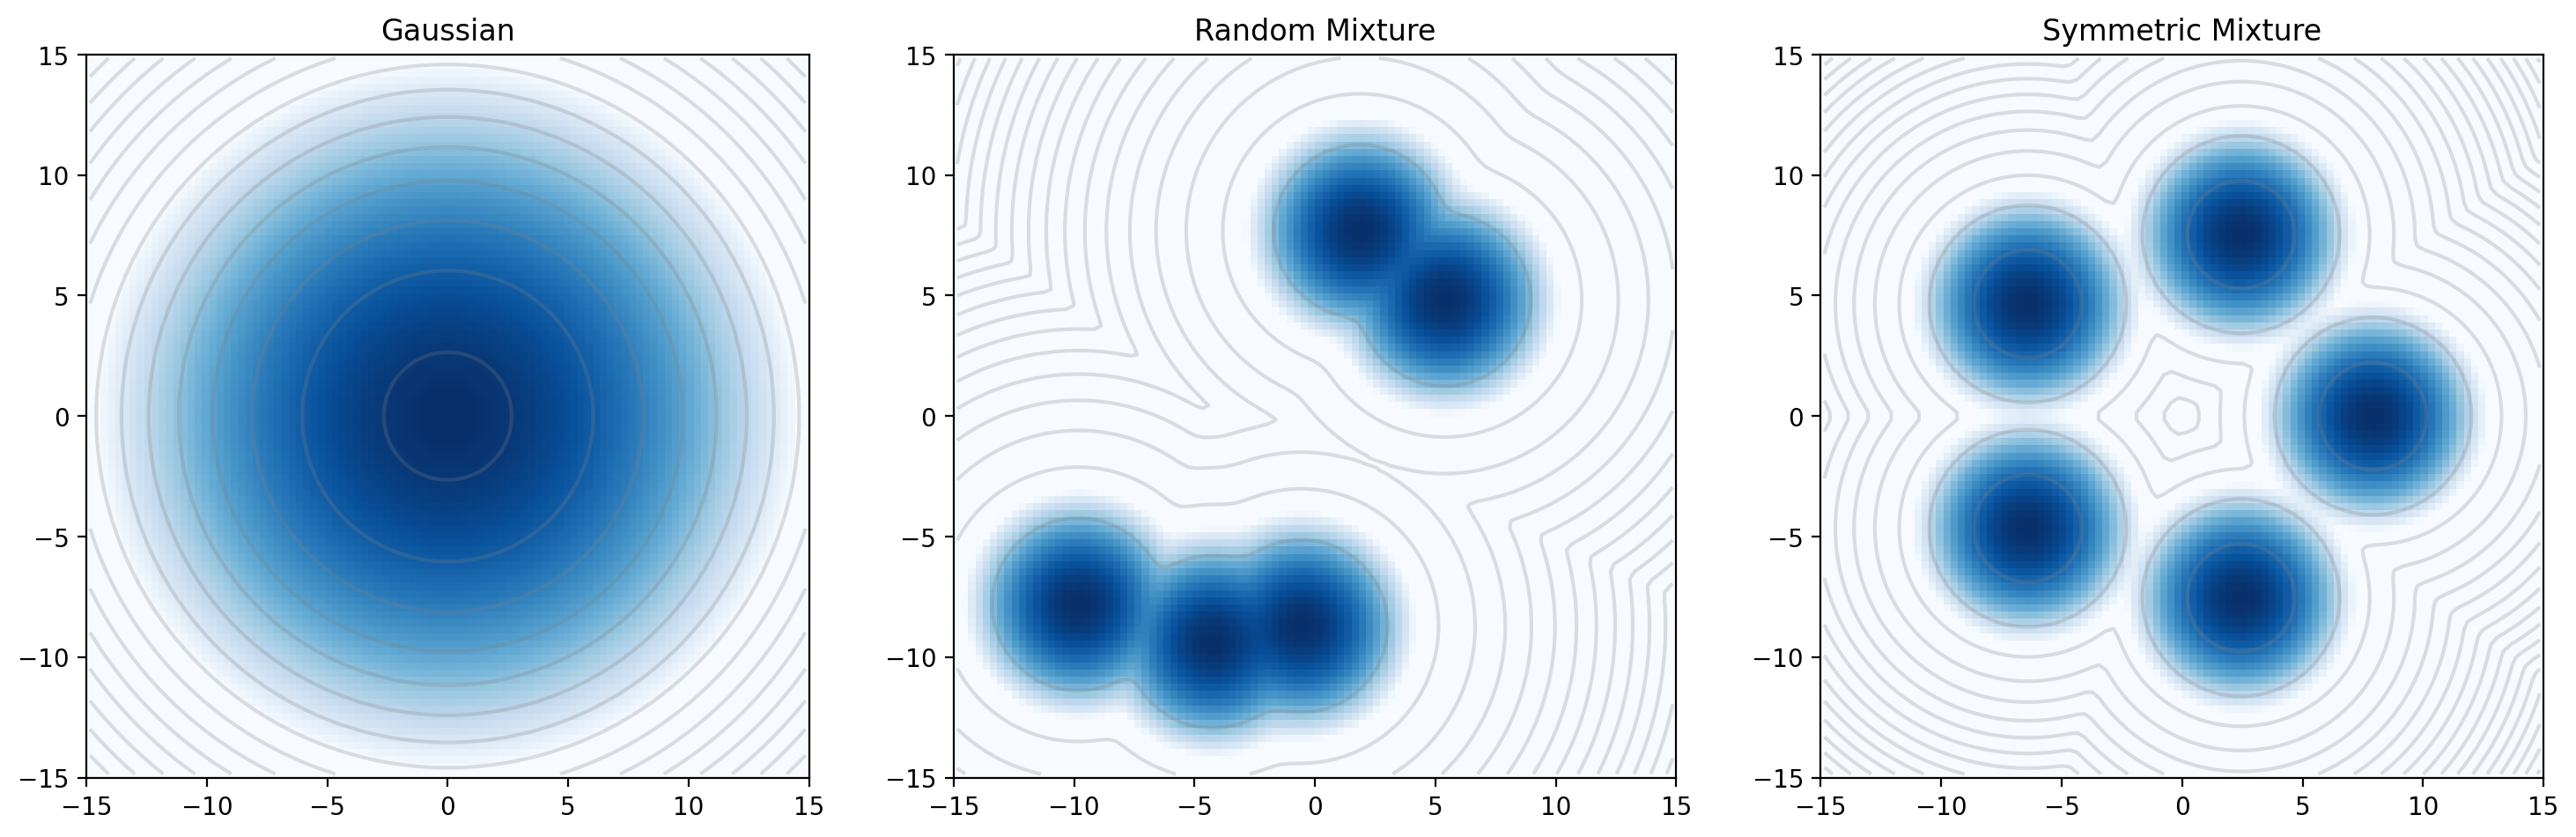

In [ ]:
def plot_densities():
    densities = {
        "Gaussian": Gaussian(mean=torch.zeros(2), cov=10 * torch.eye(2)).to(device),
        "Random Mixture": GaussianMixture.random_2D(nmodes=5, std=1.0, scale=20.0, seed=3.0).to(device),
        "Symmetric Mixture": GaussianMixture.symmetric_2D(nmodes=5, std=1.0, scale=8.0).to(device),
    }

    fig, axes = plt.subplots(1,3, figsize=(18, 6))
    bins = 100
    scale = 15
    for idx, (name, density) in enumerate(densities.items()):
        ax = axes[idx]
        ax.set_title(name)
        imshow_density(density, bins, scale, ax, vmin=-15, cmap=plt.get_cmap('Blues'))
        contour_density(density, bins, scale, ax, colors='grey', linestyles='solid', alpha=0.25, levels=20)
    plt.show()

plot_densities()

## Implementing Langevin Dynamics

In this section, we'll simulate the (overdamped) Langevin dynamics
.

$$dX_t = \displaystyle \frac{1}{2}\sigma^2 \nabla \log p(X_t) dt + \sigma dW_t$$

In [ ]:


class LangevinSDE(SDE):
    def __init__(self, sigma: float, density: Density):
        self.sigma = sigma
        self.density = density

    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the drift coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs, dim)
            - t: time, shape ()
        Returns:
            - drift: shape (bs, dim)
        """
        return self.density.score(xt) * (self.sigma ** 2) * 0.5


    def diffusion_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the diffusion coefficient of the ODE.
        Args:
            - xt: state at time t, shape (bs, dim)
            - t: time, shape ()
        Returns:
            - diffusion: shape (bs, dim)
        """
        return torch.ones(xt.shape) * self.sigma




In [ ]:
def every_nth_index(num_timesteps: int, n: int) -> torch.Tensor:
    """
    Compute the indices to record in the trajectory given a record_every parameter
    """
    if n == 1:
        return torch.arange(num_timesteps)
    return torch.cat(
        [
            torch.arange(0, num_timesteps - 1, n),
            torch.tensor([num_timesteps - 1]),
        ]
    )

def graph_dynamics(
    num_samples: int,
    source_distribution: Sampleable,
    simulator: Simulator, 
    density: Density,
    timesteps: torch.Tensor, 
    plot_every: int,
    bins: int,
    scale: float
):
    """
    Plot the evolution of samples from source under the simulation scheme given by simulator (itself a discretization of an ODE or SDE).
    Args:
        - num_samples: the number of samples to simulate
        - source_distribution: distribution from which we draw initial samples at t=0
        - simulator: the discertized simulation scheme used to simulate the dynamics
        - density: the target density
        - timesteps: the timesteps used by the simulator
        - plot_every: number of timesteps between consecutive plots
        - bins: number of bins for imshow
        - scale: scale for imshow
    """
    # Simulate
    x0 = source_distribution.sample(num_samples)
    xts = simulator.simulate_with_trajectory(x0, timesteps)
    indices_to_plot = every_nth_index(len(timesteps), plot_every)
    plot_timesteps = timesteps[indices_to_plot]
    plot_xts = xts[:,indices_to_plot]

    # Graph
    fig, axes = plt.subplots(2, len(plot_timesteps), figsize=(8*len(plot_timesteps), 16))
    axes = axes.reshape((2,len(plot_timesteps)))
    for t_idx in range(len(plot_timesteps)):
        t = plot_timesteps[t_idx].item()
        xt = plot_xts[:,t_idx]
        # Scatter axes
        scatter_ax = axes[0, t_idx]
        imshow_density(density, bins, scale, scatter_ax, vmin=-15, alpha=0.25, cmap=plt.get_cmap('Blues'))
        scatter_ax.scatter(xt[:,0].cpu(), xt[:,1].cpu(), marker='x', color='black', alpha=0.75, s=15)
        scatter_ax.set_title(f'Samples at t={t:.1f}', fontsize=15)
        scatter_ax.set_xticks([])
        scatter_ax.set_yticks([])

        # Kdeplot axes
        kdeplot_ax = axes[1, t_idx]
        imshow_density(density, bins, scale, kdeplot_ax, vmin=-15, alpha=0.5, cmap=plt.get_cmap('Blues'))
        sns.kdeplot(x=xt[:,0].cpu(), y=xt[:,1].cpu(), alpha=0.5, ax=kdeplot_ax,color='grey')
        kdeplot_ax.set_title(f'Density of Samples at t={t:.1f}', fontsize=15)
        kdeplot_ax.set_xticks([])
        kdeplot_ax.set_yticks([])
        kdeplot_ax.set_xlabel("")
        kdeplot_ax.set_ylabel("")

    plt.show()



In [ ]:
gmm_std_dev_slider = mo.ui.slider(start = 0.1, stop = 2, step=0.1)
nmode_slider = mo.ui.slider(start = 2, stop = 10, step = 1)

{"nmodes": nmode_slider, "gmm_std_dev": gmm_std_dev_slider}

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 661.23it/s]


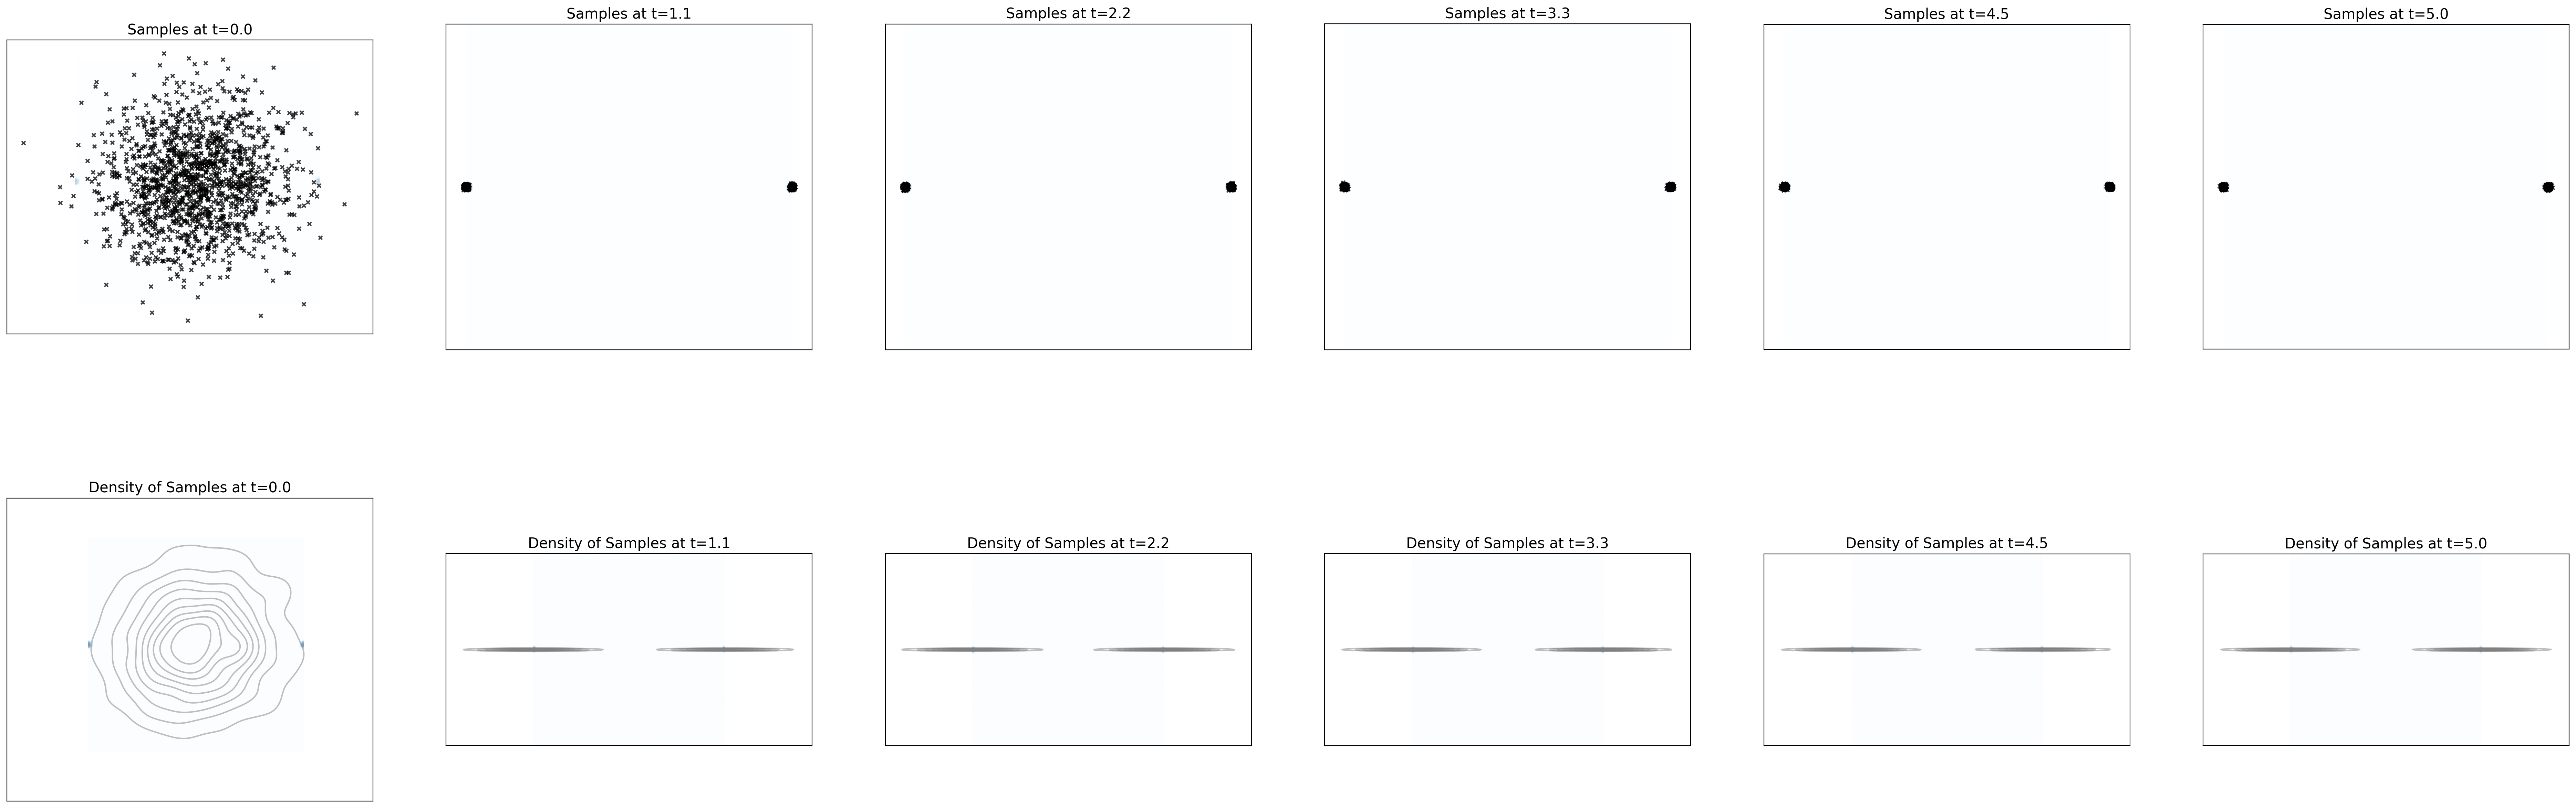

In [ ]:

std = gmm_std_dev_slider.value
nmodes = nmode_slider.value

# Construct the simulator
# target = GaussianMixture.random_2D(nmodes=nmodes, std=std, scale=15.0, seed=3.0).to(device)
target = GaussianMixture.symmetric_2D(nmodes=nmodes, std=std, scale=15.0).to(device)
sde = LangevinSDE(sigma = 0.9, density = target)
simulator = EulerMaruyamaSimulator(sde)

# Graph the results!
graph_dynamics(
    num_samples = 1500,
    source_distribution = Gaussian(mean=torch.zeros(2), cov=30 * torch.eye(2)).to(device),
    simulator=simulator,
    density=target,
    timesteps=torch.linspace(0,5.0,1500).to(device),
    plot_every=334,
    bins=200,
    scale=15
)   

In [ ]:
from celluloid import Camera
from IPython.display import HTML

def animate_dynamics(
    num_samples: int,
    source_distribution: Sampleable,
    simulator: Simulator, 
    density: Density,
    timesteps: torch.Tensor, 
    animate_every: int,
    bins: int,
    scale: float,
    save_path: str = 'dynamics_animation.mp4'
):
    """
    Plot the evolution of samples from source under the simulation scheme given by simulator (itself a discretization of an ODE or SDE).
    Args:
        - num_samples: the number of samples to simulate
        - source_distribution: distribution from which we draw initial samples at t=0
        - simulator: the discertized simulation scheme used to simulate the dynamics
        - density: the target density
        - timesteps: the timesteps used by the simulator
        - animate_every: number of timesteps between consecutive frames in the resulting animation
    """
    # Simulate
    x0 = source_distribution.sample(num_samples)
    xts = simulator.simulate_with_trajectory(x0, timesteps)
    indices_to_animate = every_nth_index(len(timesteps), animate_every)
    animate_timesteps = timesteps[indices_to_animate]
    animate_xts = xts[:, indices_to_animate]

    # Graph
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    camera = Camera(fig)
    for t_idx in range(len(animate_timesteps)):
        t = animate_timesteps[t_idx].item()
        xt = animate_xts[:,t_idx]
        # Scatter axes
        scatter_ax = axes[0]
        imshow_density(density, bins, scale, scatter_ax, vmin=-15, alpha=0.25, cmap=plt.get_cmap('Blues'))
        scatter_ax.scatter(xt[:,0].cpu(), xt[:,1].cpu(), marker='x', color='black', alpha=0.75, s=15)
        scatter_ax.set_title(f'Samples')

        # Kdeplot axes
        kdeplot_ax = axes[1]
        imshow_density(density, bins, scale, kdeplot_ax, vmin=-15, alpha=0.5, cmap=plt.get_cmap('Blues'))
        sns.kdeplot(x=xt[:,0].cpu(), y=xt[:,1].cpu(), alpha=0.5, ax=kdeplot_ax,color='grey')
        kdeplot_ax.set_title(f'Density of Samples', fontsize=15)
        kdeplot_ax.set_xticks([])
        kdeplot_ax.set_yticks([])
        kdeplot_ax.set_xlabel("")
        kdeplot_ax.set_ylabel("")
        camera.snap()

    animation = camera.animate()
    animation.save(save_path)
    plt.close()
    return HTML(animation.to_html5_video())


In [ ]:
# OPTIONAL CELL
# Construct the simulator
new_target = GaussianMixture.symmetric_2D(nmodes=5, std=0.5, scale=15.0).to(device)
new_sde = LangevinSDE(sigma = 0.6, density = target)
new_simulator = EulerMaruyamaSimulator(new_sde)

# Graph the results!
animate_dynamics(
    num_samples = 1000,
    source_distribution = Gaussian(mean=torch.zeros(2), cov=30 * torch.eye(2)).to(device),
    simulator=new_simulator,
    density=new_target,
    timesteps=torch.linspace(0,5.0,1000).to(device),
    bins=200,
    scale=15,
    animate_every=100
)   

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 1510.60it/s]


<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAw9RtZGF0AAACrgYF//+q
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzEwOCAzMWUxOWY5IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMyAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTEy
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj01IHNjZW5lY3V0PTQwIGludHJhX3Jl
ZnJlc2g9MCByY19sb29rYWhlYWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAu
NjAgcXBtaW49MCBxcG1heD02OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAACm
XmWIhAAT//73sY+BTcgADZc6inof4RWx9JBRerHZoGTqAAADAAADAAADAAADAAC/prVjeQY1s08J
AAADAAADAA/AAABlgAAEVAAAQsAABqUJj+0h3t+AA5Z/dD1X5PML6eX4C9uR4Vs3eZ+2wXuxuyx/
C8/ue2jw12cDsoP1U/jarGo6sACOHx9Mk/H44TB5ax0gjEiCqgU5VhaqF0KC6at7VY6IRcHXkktF
zKvPMbhaEqh5LZEu/p2pulpvLOA5dIY7Q51NBaYxlR69OjWorNfkmwt0qn7P1GyVcMzIlKSylp1E
baA4zmkGV+kTDvxBHt/aq5EEuz2d0EL2LfFVoWIiX9wNVgyLxsx+xmgDbwAEhetO9p7ioOmmyfKF
OmrQFqk39+LkJIfituzUvfXmTrekEjAfl8lTV41IRo1XnhIc96ZKnVkJt6sgla7UGfhjUsxebv0k
A6geIwfnDfQLFi+iyxGCxuURSsHu1nWK8PZwuiPQShBYgEb69TOWQ+0KodkUTjDHJUhJ6ed3g+fT
ny+MGEC8IinHlNyvc1XKL6z7DZ2XgrW7ZyVSjBlxFsjnE4C9GB0m7CzOHRDbIZjFtgdjRbcCuj/I
Xt0iYj4d2TwVSuTNXea/d/SK3R98/DFecZkoUTLxwdU0HALjMvOMaJVAzvuFgQt7gkz7fFYNlW5p
X5KpyZlwD0+2gamZ9gtIaxDTEsxCPlJaOegG3+rBstFUN26to+OlcNQFecb3pgDunI83BCtfoXFl
6gbPEz12OqE6roY7o7iLj4F1PrTWkUa1CkBxcIQHvH7zHO70daAnHYSjGxbpQakszSdLbqD1K2vW
6jN7ID9mP8vcbRSCXDw3enwr4AFwTEbsBmsA+8rvr4h9k5/nzsdArZpNyXvLGqlMvarQKKpHb9Jf
I7ZaADbeDiW6XtusmGzi7l8UAp4Ur3+5r9I7KNV7bAAAiJnkJl6AStiV9mbzoS4Xsq4aSM4OSNKO
BIy6Fgk3g/chZ1/KwNEdnDEcSDOwW3fA4NuTW3ifR1oD7kNl+djlDQVUcoYaTfcG6c0a83aV6NKB
AQ1LC8uEzPdypyRJftsZ0E2gRNMpx0cZ5b1XCeDjtpPGSbi4ggJ8FnhWm/zq4eJiDZneVU3d+kFW
knPR9MSvShzDLZR1Ni74/HettzozmcvN3jnqfYVFdSs5Lr7oZ4OjU3CKyQruLs1bbrisysDZ/zsm
tlQ7Gl8lC7/Qwkc/NM3vOzIqJvhNneDTesVETdBKdemDm0Cish9OtUgVlO74y+l/kh0iql1imVNv
9Flpy7dlu5X5YRN1dfDemG1Ud6La84rc1RAT+OivUNxF15btnVPKmAtNWvCSC5L7VgQpT/sg29b8
FN1tk1liyQKVhQtKT+MFQ/6gAE2EPn1t0UQboBLvVQIQ/rQFf3oC4q6m/pUzWHObeFxkWzlSbive
rOPi6czSLuEg4bDidMQ4PkjjUHHjwIqEtZ/AAsAu5bZLmjeUCI3oNuqYxaJbfMfzkERk/z5ITiVS
dAUyhWSxm8bJf455PtP6Z+VPr8LFuI84+FUYby+7mkIFWR/g2noTdufKck/sth+dcdM4qe/mCVYm
C25s7PCKnAkG8v/tiauvFWYfcUIQz4mRp6F6hMY7j7Eh6E74VwQLrm67Ofe+W1qTmn0vs56/X8DG
1PC7zLKKhCQqHaBds5n7LUEtyKlKuW5xnr6CyrDP2MEhQ2h1KSG+D4PJuN7wzy7dS9Ym7kCEaiOm
rQ+sP6DcTHLfCeIKX6fyR60zoezpIli8S7+Y6J3eRlbSDi1L6W6ay3WWhC/xxdFh6X4E5NAKBsIB
ZJ3k+HdH5M0Gl1DCIh2yD4r9VMgXQn7npyAQqA8q7ulxCBENDeqCG/clC80FFSSRr1nTzqU+ipfn
O3wi463HaaJyIZBt/F4L3/6tlzbUStF0FPBTHdbrJPFjxQ9VF9foRvlTwFLb74THvfYb9Z2ytxbO
jT9aFH/6o137FzwEDQnLP9S2tzmhu6+JfSZBXJUtUgrzVMtnXFlgoqWVGjGCPDa39Xjh7rm/SQXv
/wKhfOWZaYFf32zRhIDJIHiNqoD0qOGMYDb4hk9dvhsnnTN2E5YCiqRx6uVWpfCpow1fFd+p+5Eb
O5jxh/N+FNtStkIO8oigD/lSDUJrFrjsWpuUv1Bmy2d55AlUtIy5vfsvjGRHl17xjVWN3ksrKPyE
s5FgeT6sSzWUUKmH6zLIf5Rf3uDSvMSaIAiuJZePAIj3/6dCCq7A4Kx2TvC+L41jbRv1BCN4yBFu
vwOVDhsk9GTB5ExlQHpKo82o6zKNqulqW/6X8lAEsSXjiTG9oVvm0eAoyRnUnTqpoa8MUQZQ2wOS
amEuU072sBks0DaDfx52dbrutaWEXYPBV5E4kEpEVLEyz5B+02I7C+rM8Axa4cgkoVCxbmq7fYjE
Gmt+cZEOZEMmWQsBMd5h55SwCYdJ55Pzq1fRvyr2bUFa2MLcqbYV8hB/u6SiiDHDNbYGcNePK6nE
a2KYHnWavQc4oxnuSAIVuaQdo46Ca9zglfz2qhBzM3kp8Z/wRCC6EhytLJSwT7pbowD3HQddomYl
Q1x/4otCZpmlfcJB/5cHyEa6r5p5+7Ed+gswI/BsndJm7IuUhdcCydZmPa31QhjE80RbFLCA2N0j
04eHGh97VgW2nc0NRfqXCIh4K1rapmAs0tTv+fSlmJSXVCMvIM5M/fLlUiwEA0r94zvSDbRW06W1
2S4JGnYsqK4gi45ewL90jhv5/QAN4SHeh6PuDvHuDwwTLEtP7RsgyUMndJOXW0o5GKPS9Hx77eHS
r5j/XbjZoHAzqXDNzdkgVwzCWWhLPtXWBpK5TPBGOQD8iEck8Utof28yKdo57wzi1XlkGb7uZ2C9
MuaYGQ719god91UIo81e6